In [1]:
!pip install git+https://github.com/IBM/tsfm.git
!pip install transformers

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-18ajk4y_
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-18ajk4y_
  Resolved https://github.com/IBM/tsfm.git to commit 3dcb7540879d66d622de182f316760237a1b8695
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [3]:
# Skip this cell after initial run
from google.colab import files
uploaded = files.upload()

Saving Native_Load_2024.xlsx to Native_Load_2024.xlsx


In [4]:
import torch
import pandas as pd
import numpy as np
from transformers import PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset

# Load and preprocess ERCOT data
def load_ercot_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    df['Hour Ending'] = df['Hour Ending'].str.replace(' 24:00', ' 00:00')
    df['Hour Ending'] = pd.to_datetime(df['Hour Ending'].str.split().str[0] + ' ' + df['Hour Ending'].str.split().str[1], format='%m/%d/%Y %H:%M', errors='coerce') + pd.Timedelta(days=1)
    df.dropna(subset=['Hour Ending'], inplace=True)
    df.set_index('Hour Ending', inplace=True)
    return df

# Aggregate hourly data to daily data
def aggregate_to_daily(data):
    area_sums = data[['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST']].resample('D').sum()
    ercot_sum = data['ERCOT'].resample('D').sum()
    daily_data = pd.concat([area_sums, ercot_sum], axis=1)
    return daily_data

# Normalize the data
def normalize_data(data):
    return (data - data.mean()) / data.std()

# Load dataset
file_path = "Native_Load_2024.xlsx"
ercot_data = load_ercot_data(file_path)
daily_ercot_data = aggregate_to_daily(ercot_data)
normalized_data = normalize_data(daily_ercot_data)

# Prepare input and target data
context_length = 276
prediction_length = 30

X = []
y = []

for i in range(len(normalized_data) - context_length - prediction_length + 1):
    X.append(normalized_data.iloc[i:i+context_length].values)
    y.append(normalized_data.iloc[i+context_length:i+context_length+prediction_length].values)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Custom Dataset class to return dicts in the correct format for the model
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, context_length, prediction_length):
        self.X = X
        self.y = y
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Prepare the dictionary with the expected keys
        past_values = self.X[idx]  # Context window
        future_values = self.y[idx]  # Prediction target
        # Create a dictionary to return in the expected format
        return {
            'past_values': past_values,
            'future_values': future_values,
            'labels': future_values
        }

# Create the datasets
train_dataset = TimeSeriesDataset(X, y, context_length, prediction_length)
eval_dataset = TimeSeriesDataset(X, y, context_length, prediction_length)

# Define model configuration
config = PatchTSTConfig(
    num_input_channels=normalized_data.shape[1],
    prediction_length=30,
    context_length=276,
    patch_length=16,
    patch_stride=8,
    num_hidden_layers=4,
    d_model=128,
    num_attention_heads=4,
    ffn_dim=256,
    norm_type='layernorm',
    positional_encoding_type='sincos'
)

model = PatchTSTForPrediction(config)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

# Train the model
trainer.train()

<ipython-input-4-7da79c96f984>:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X, dtype=torch.float32)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thy-orcas (thy-orcas-university-of-washington) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,No log
2,No log,No log
3,0.715500,No log
4,0.715500,No log
5,0.628700,No log
6,0.628700,No log
7,0.628700,No log
8,0.552400,No log
9,0.552400,No log
10,0.524800,No log


TrainOutput(global_step=40, training_loss=0.6053512215614318, metrics={'train_runtime': 104.9591, 'train_samples_per_second': 5.812, 'train_steps_per_second': 0.381, 'total_flos': 4911104973600.0, 'train_loss': 0.6053512215614318, 'epoch': 10.0})

In [5]:
# Evaluate Model
def evaluate_model(model, dataset):
    # Set the model to evaluation mode
    model.eval()

    # Lists to hold predictions and true targets
    all_predictions = []
    all_targets = []

    X_data = dataset[0]  # Dataset
    y_data = dataset[1]  # Labels

    target_sequence_length = 276  # The model expects sequence length of 276

    # Iterate over the dataset and get predictions
    for i in range(len(X_data)):
        input_data = torch.tensor(X_data[i]).unsqueeze(0)  # Add batch dimension

        # Ensure that input_data has the correct shape: (batch_size, sequence_length, feature_size)
        if input_data.shape[1] != target_sequence_length:
            # Pad or truncate if sequence length is incorrect
            input_data = torch.zeros(1, target_sequence_length, input_data.shape[-1])  # Pad to correct sequence length

        target_data = torch.tensor(y_data[i]).unsqueeze(0)  # Add batch dimension

        # Make prediction
        with torch.no_grad():  # Disable gradient calculation for evaluation
            output = model(input_data)
            predictions = output.prediction_outputs.squeeze().numpy()  # Get the prediction

        # Store predictions and targets
        all_predictions.append(predictions)
        all_targets.append(target_data.numpy().squeeze())

    # Convert the lists to arrays for easier metric calculation
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Flatten the predictions and targets to 2D arrays (batch_size * sequence_length, feature_size)
    all_predictions_flat = all_predictions.reshape(-1, all_predictions.shape[-1])
    all_targets_flat = all_targets.reshape(-1, all_targets.shape[-1])

    # Calculate performance metrics
    mse = mean_squared_error(all_targets_flat, all_predictions_flat)
    mae = mean_absolute_error(all_targets_flat, all_predictions_flat)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
    return all_predictions

# Run evaluation
predictions = evaluate_model(model, (X, y))  # Pass your train/eval dataset as a tuple (inputs, targets)


<ipython-input-5-b4f350fc7808>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(X_data[i]).unsqueeze(0)  # Add batch dimension
<ipython-input-5-b4f350fc7808>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_data = torch.tensor(y_data[i]).unsqueeze(0)  # Add batch dimension


MSE: 0.5217458009719849, MAE: 0.5892199873924255, RMSE: 0.7223197359701484


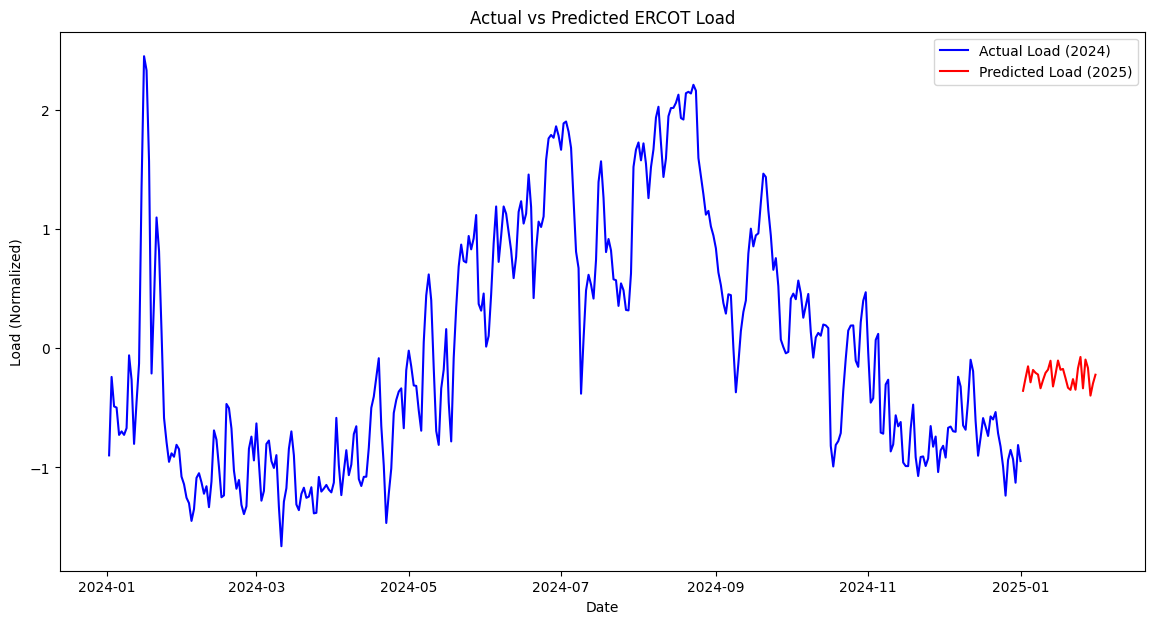

In [6]:
import matplotlib.pyplot as plt

ercot_predictions = predictions[:, -30:, 0]  # Get the last 30 days for ERCOT

# Calculate the mean of the predictions across the samples
ercot_predictions_mean = ercot_predictions.mean(axis=0)

# Generate forecast dates (30 days after the last date in the original dataset)
forecast_dates = pd.date_range(start=normalized_data.index[-1] + pd.Timedelta(days=1), periods=30)

# Create a DataFrame with the forecast dates and predicted ERCOT load
forecast_df = pd.DataFrame(ercot_predictions_mean, index=forecast_dates, columns=['ERCOT'])

# Plot the actual and predicted loads
plt.figure(figsize=(14, 7))
plt.plot(normalized_data.index, normalized_data['ERCOT'], label='Actual Load (2024)', color='blue')
plt.plot(forecast_dates, forecast_df['ERCOT'], label='Predicted Load (2025)', color='red')
plt.xlabel('Date')
plt.ylabel('Load (Normalized)')
plt.title('Actual vs Predicted ERCOT Load')
plt.legend()
plt.show()

In [7]:
# Skip this cell after initial run
uploaded = files.upload()

Saving Native_Load_2025.xlsx to Native_Load_2025.xlsx


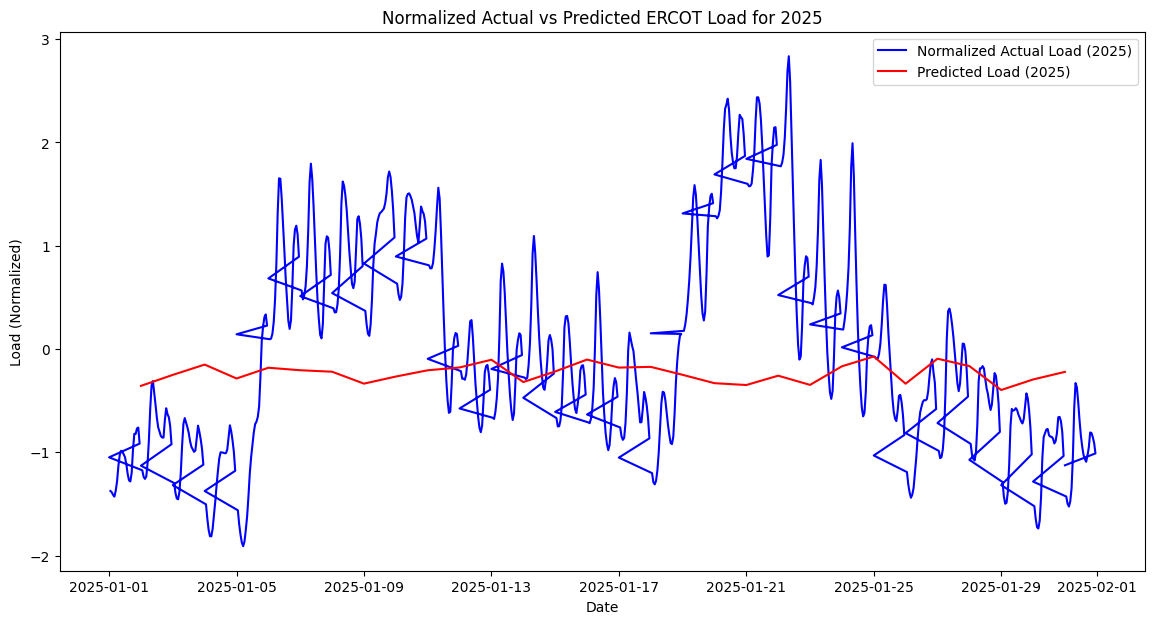

In [8]:
# Load and preprocess 2025 data
import os
path = os.getcwd()
df2 = pd.read_excel(path + "/Native_Load_2025.xlsx")
df2.dropna(inplace=True)
df2['Hour Ending'] = (df2['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df2['Hour Ending'] = pd.to_datetime(df2['Hour Ending'], format='%m/%d/%Y %H:%M')
df2.set_index('Hour Ending', inplace=True)
df2['hour'] = df2.index.hour
df2['dayofweek'] = df2.index.dayofweek
df2['dayofyear'] = df2.index.dayofyear

# Normalize actual load (2025)
normalized_actual_load_2025 = normalize_data(df2[['ERCOT']])

# Plot normalized actual vs predicted loads
plt.figure(figsize=(14, 7))
plt.plot(normalized_actual_load_2025.index, normalized_actual_load_2025['ERCOT'], label='Normalized Actual Load (2025)', color='blue')
plt.plot(forecast_dates, forecast_df['ERCOT'], label='Predicted Load (2025)', color='red')
plt.xlabel('Date')
plt.ylabel('Load (Normalized)')
plt.title('Normalized Actual vs Predicted ERCOT Load for 2025')
plt.legend()
plt.show()